# Proyecto Final: Análisis completo del dataset

## Introducción y Contexto del Problema

### Descripción del Problema
En los procesos de verificación de identidad con prueba de vida (liveness) dentro de la organización, no se cuenta con un mecanismo que permita contrastar la edad declarada en un documento con la edad aparente del rostro de la persona. Esto genera riesgos de fraude y suplantación, incrementa los tiempos de revisión manual y afecta la eficiencia de procesos críticos como el onboarding digital, KYC/KYB y validaciones en entornos de alta seguridad.

### Justificación del uso de Ciencia de Datos
El problema puede resolverse aplicando técnicas de regresión lineal para desarrollar un modelo de estimación de edad aparente considerando factores de calidad de imagen como **blur**, **haze** y **sharpness**.

### Pregunta SMART
"¿Cuál es el impacto del blur, haze y sharpness en la precisión de un modelo de estimación de edad aparente basado en regresión lineal, medido como reducción del error medio absoluto por debajo de 5 años, en un periodo de validación de 4 semanas utilizando dataset propio y externo?"

### Objetivo
Determinar la importancia de las variables de calidad de imagen (sharpness, blur, haze) como predictores de la edad real mediante un modelo de regresión lineal.

---

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [62]:
# Carga y exploración inicial del dataset
df = pd.read_csv("demo_faces.csv")

print("EXPLORACIÓN INICIAL DEL DATASET")
print("=" * 50)
print(f"Dimensiones del DataFrame: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\n Información general del dataset:")
df.info()

print("\n Primeras 5 filas del dataset:")
display(df.head())

print("\n Estadísticas descriptivas:")
display(df.describe())

EXPLORACIÓN INICIAL DEL DATASET
Dimensiones del DataFrame: (420, 10)
Número de filas: 420
Número de columnas: 10

 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   true_age      420 non-null    int64  
 1   pred_age      420 non-null    float64
 2   error_pct     420 non-null    float64
 3   sharpness     420 non-null    float64
 4   blur          420 non-null    int64  
 5   haze          420 non-null    float64
 6   face_area     420 non-null    int64  
 7   image_width   420 non-null    int64  
 8   image_height  420 non-null    int64  
 9   image_pixels  420 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 32.9 KB

 Primeras 5 filas del dataset:


,true_age,pred_age,error_pct,sharpness,blur,haze,face_area,image_width,image_height,image_pixels
0,67,74.2,10.692007,95.627130,1,0.295987,8030,800,480,384000
1,43,41.1,4.373228,111.293125,4,0.334095,11077,640,768,491520
2,59,59.2,0.291838,66.966927,2,0.094719,5985,1280,480,614400
3,55,59.3,7.796279,69.114813,0,0.635800,10836,480,960,460800
4,45,47.9,6.432586,68.022421,4,0.670173,7695,800,768,614400



 Estadísticas descriptivas:


,true_age,pred_age,error_pct,sharpness,blur,haze,face_area,image_width,image_height,image_pixels
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,4.200000e+02
mean,43.011905,45.169048,9.255277,79.978979,4.950000,0.410921,16511.740476,803.504762,612.457143,4.928311e+05
std,15.766717,15.996087,9.241165,24.453451,3.239063,0.235525,9842.915482,272.871100,199.399817,2.431788e+05
min,15.000000,11.200000,0.002514,5.000000,0.000000,0.003445,2444.000000,320.000000,240.000000,7.680000e+04
25%,30.750000,32.575000,2.938454,64.934785,2.000000,0.195605,8691.500000,640.000000,480.000000,3.072000e+05
50%,43.000000,46.000000,6.453869,80.821218,5.000000,0.392238,14712.000000,800.000000,600.000000,4.800000e+05
75%,56.250000,59.225000,12.613602,95.856889,8.000000,0.629693,22758.750000,1024.000000,768.000000,6.144000e+05
max,69.000000,74.500000,51.504950,159.471342,10.000000,0.799064,45796.000000,1280.000000,960.000000,1.228800e+06


## 1. Preparación y Limpieza de Datos

Se realizará las siguientes actividades

1. **Identificar variables relevantes**: Excluir `pred_age` y `error_pct` ya que son variables derivadas de la predicción
2. **Detectar valores faltantes**: Verificar la completitud del dataset
3. **Identificar outliers**: Aplicar técnicas similares a las del análisis de `edad_aparente`
4. **Seleccionar variables predictoras**: Enfocarse en variables de calidad de imagen y características técnicas

### Variables a utilizar:
- **Variable objetivo (Y)**: `true_age` - Edad real de la persona
- **Posibles variables predictoras (X)**: `sharpness`, `blur`, `haze`, `face_area`, `image_width`, `image_height`, `image_pixels`

In [63]:
# 1.1 Selección de variables relevantes y detección de valores faltantes
print("PREPARACIÓN Y LIMPIEZA DE DATOS")
print("=" * 50)

# Excluir variables derivadas de la predicción
variables_excluir = ['pred_age', 'error_pct']
print(f"Variables excluidas: {variables_excluir}")

# Definir variables a utilizar
variable_objetivo = 'true_age'
variables_predictoras = ['sharpness', 'blur', 'haze', 'face_area', 'image_width', 'image_height', 'image_pixels']

print(f"Variable objetivo: {variable_objetivo}")
print(f"Variables predictoras: {variables_predictoras}")

# Crear dataset limpio
df_modelo = df[variables_predictoras + [variable_objetivo]].copy()

# Verificar valores faltantes
print("\n VERIFICACIÓN DE VALORES FALTANTES:")
valores_faltantes = df_modelo.isnull().sum()
print(valores_faltantes)

if valores_faltantes.sum() == 0:
    print("No se encontraron valores faltantes")
else:
    print(f"Se encontraron {valores_faltantes.sum()} valores faltantes")
    
print(f"\nDimensiones del dataset para modelado: {df_modelo.shape}")

PREPARACIÓN Y LIMPIEZA DE DATOS
Variables excluidas: ['pred_age', 'error_pct']
Variable objetivo: true_age
Variables predictoras: ['sharpness', 'blur', 'haze', 'face_area', 'image_width', 'image_height', 'image_pixels']

 VERIFICACIÓN DE VALORES FALTANTES:
sharpness       0
blur            0
haze            0
face_area       0
image_width     0
image_height    0
image_pixels    0
true_age        0
dtype: int64
No se encontraron valores faltantes

Dimensiones del dataset para modelado: (420, 8)


### Análisis univariado de `true_age`

ANÁLISIS UNIVARIADO DE 'true_age'
Estadísticas descriptivas de 'true_age':


count    420.000000
mean      43.011905
std       15.766717
min       15.000000
25%       30.750000
50%       43.000000
75%       56.250000
max       69.000000
Name: true_age, dtype: float64


Información adicional:
Moda: [61]
Valores únicos: 55
Rango: 54


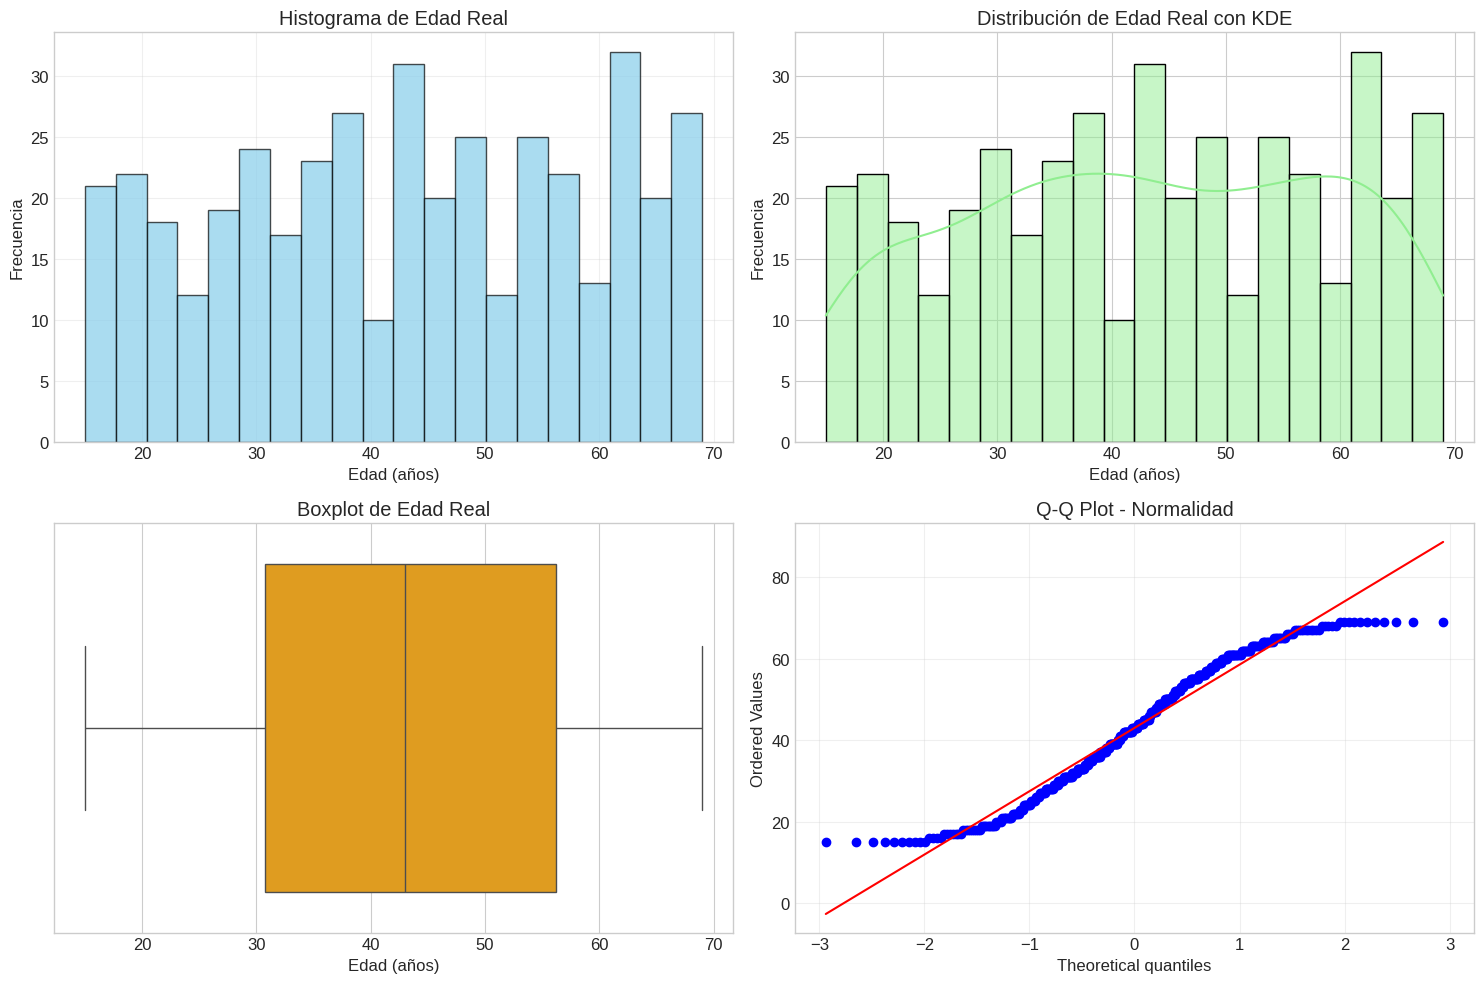


Test de Shapiro-Wilk para normalidad:
Estadístico: 0.9568
P-valor: 0.0000
¿Es normal? No (α = 0.05)


In [64]:
# 1.2 Análisis univariado de la variable objetivo (aplicando conocimientos del Taller 1)
print("ANÁLISIS UNIVARIADO DE 'true_age'")
print("=" * 50)

# Estadísticas descriptivas
print("Estadísticas descriptivas de 'true_age':")
display(df_modelo['true_age'].describe())

# Información adicional
print(f"\nInformación adicional:")
print(f"Moda: {df_modelo['true_age'].mode().values}")
print(f"Valores únicos: {df_modelo['true_age'].nunique()}")
print(f"Rango: {df_modelo['true_age'].max() - df_modelo['true_age'].min()}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma con KDE
axes[0, 0].hist(df_modelo['true_age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Histograma de Edad Real')
axes[0, 0].set_xlabel('Edad (años)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma con curva de densidad
sns.histplot(df_modelo['true_age'], bins=20, kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribución de Edad Real con KDE')
axes[0, 1].set_xlabel('Edad (años)')
axes[0, 1].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df_modelo['true_age'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Boxplot de Edad Real')
axes[1, 0].set_xlabel('Edad (años)')

# Q-Q plot para normalidad
stats.probplot(df_modelo['true_age'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Normalidad')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalidad
shapiro_stat, shapiro_p = stats.shapiro(df_modelo['true_age'])
print(f"\nTest de Shapiro-Wilk para normalidad:")
print(f"Estadístico: {shapiro_stat:.4f}")
print(f"P-valor: {shapiro_p:.4f}")
print(f"¿Es normal? {'Sí' if shapiro_p > 0.05 else 'No'} (α = 0.05)")

### Conclusiones del Análisis Univariado de `true_age`

**Hallazgos Principales:**

1. **Distribución y Tendencia Central:**
   - Media de 43.01 años muy cercana a la mediana (43.00), sugiriendo simetría aproximada en la tendencia central
   - Desviación estándar de 15.77 años indica variabilidad considerable
   - Rango amplio de 54 años (15-69 años) proporciona excelente diversidad para el modelo

2. **Características de la Distribución:**
   - **Distribución claramente bimodal** con dos picos bien definidos:
     - **Primer pico**: ~40 años (adultos jóvenes)
     - **Segundo pico**: ~60 años (adultos mayores)
   - **No sigue distribución normal** (p < 0.001 en test Shapiro-Wilk)
   - **Q-Q Plot** muestra patrón en "S" típico de distribuciones bimodales
   - **Sin outliers estadísticos**: El boxplot confirma que todos los valores están dentro del rango esperado (1.5×IQR)

3. **Calidad de los Datos:**
   - 55 valores únicos de edad ofrecen buena granularidad
   - Moda en 61 años refleja concentración en el segundo pico etario
   - **Rango biológicamente válido**: Todas las edades (15-69 años) son plausibles para el contexto

**🔍 Implicaciones para el Modelo de Regresión:**

**Aspectos Positivos:**
- Amplio rango etario permite excelente generalización
- Buena variabilidad en la variable objetivo sin datos problemáticos
- Ausencia de outliers reduce riesgo de sesgo en el modelo

**Consideraciones:**
- La **falta de normalidad** requerirá validación cuidadosa de supuestos de regresión lineal
- La **naturaleza bimodal** sugiere dos poblaciones etarias predominantes que podrían comportarse diferente
- Posible necesidad de evaluar si el modelo captura adecuadamente ambos grupos etarios.

## 2. Análisis Bivariado de Variables de Calidad de Imagen

Analizaremos las correlaciones entre `true_age` y las variables de calidad de imagen: **sharpness**, **blur** y **haze**.

**Objetivo:** Determinar si existe relación estadísticamente significativa entre estas variables y la edad real, siguiendo el enfoque del análisis `edad vs sharpness`.

### Variables a analizar:
- **Variable dependiente (Y)**: `true_age`
- **Variables independientes principales**: `sharpness`, `blur`, `haze`
- **Variables adicionales**: `face_area`, `image_width`, `image_height`, `image_pixels`

ANÁLISIS BIVARIADO: CORRELACIONES
Correlaciones de Pearson con 'true_age':
      sharpness: r =  0.050, p =  0.3091 
           blur: r = -0.043, p =  0.3770 
           haze: r = -0.067, p =  0.1680 
      face_area: r =  0.057, p =  0.2461 
    image_width: r =  0.017, p =  0.7295 
   image_height: r = -0.026, p =  0.5971 
   image_pixels: r = -0.009, p =  0.8595 

Legenda: *** p<0.001, ** p<0.01, * p<0.05

Correlaciones de Spearman con 'true_age':
      sharpness: ρ =  0.029, p =  0.5480 
           blur: ρ = -0.042, p =  0.3949 
           haze: ρ = -0.064, p =  0.1892 
      face_area: ρ =  0.047, p =  0.3326 
    image_width: ρ =  0.020, p =  0.6845 
   image_height: ρ = -0.019, p =  0.7000 
   image_pixels: ρ = -0.013, p =  0.7932 

MATRIZ DE CORRELACIÓN COMPLETA


,sharpness,blur,haze,face_area,image_width,image_height,image_pixels,true_age
sharpness,1.000,0.030,0.029,0.030,-0.021,-0.045,-0.050,0.050
blur,0.030,1.000,-0.107,0.002,-0.048,-0.083,-0.082,-0.043
haze,0.029,-0.107,1.000,0.031,-0.000,0.036,0.010,-0.067
face_area,0.030,0.002,0.031,1.000,-0.053,0.102,0.024,0.057
image_width,-0.021,-0.048,-0.000,-0.053,1.000,0.013,0.720,0.017
image_height,-0.045,-0.083,0.036,0.102,0.013,1.000,0.663,-0.026
image_pixels,-0.050,-0.082,0.010,0.024,0.720,0.663,1.000,-0.009
true_age,0.050,-0.043,-0.067,0.057,0.017,-0.026,-0.009,1.000



MAPA DE CALOR DE CORRELACIONES


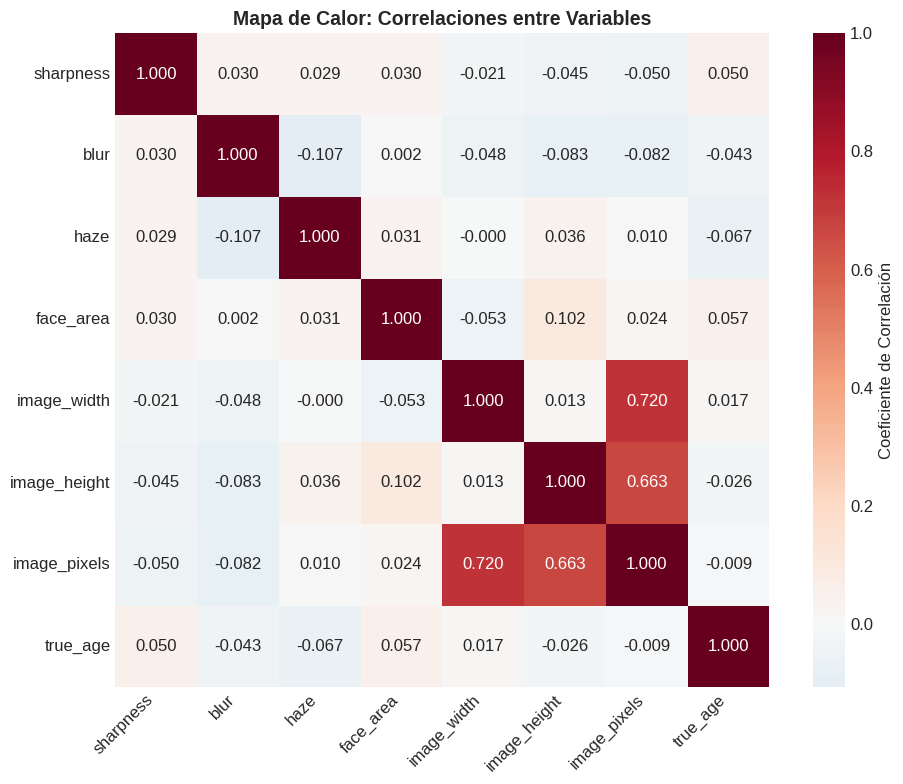

In [65]:
# 2.1 Análisis de correlaciones entre true_age y variables predictoras
print("ANÁLISIS BIVARIADO: CORRELACIONES")
print("=" * 50)

# Calcular correlaciones de Pearson
print("Correlaciones de Pearson con 'true_age':")
correlaciones_pearson = {}
for variable in variables_predictoras:
    corr_coef, p_valor = pearsonr(df_modelo[variable], df_modelo['true_age'])
    correlaciones_pearson[variable] = {'correlacion': corr_coef, 'p_valor': p_valor}
    significancia = "***" if p_valor < 0.001 else "**" if p_valor < 0.01 else "*" if p_valor < 0.05 else ""
    print(f"{variable:>15}: r = {corr_coef:>6.3f}, p = {p_valor:>7.4f} {significancia}")

print("\nLegenda: *** p<0.001, ** p<0.01, * p<0.05")

# Calcular correlaciones de Spearman
print("\nCorrelaciones de Spearman con 'true_age':")
correlaciones_spearman = {}
for variable in variables_predictoras:
    corr_coef, p_valor = spearmanr(df_modelo[variable], df_modelo['true_age'])
    correlaciones_spearman[variable] = {'correlacion': corr_coef, 'p_valor': p_valor}
    significancia = "***" if p_valor < 0.001 else "**" if p_valor < 0.01 else "*" if p_valor < 0.05 else ""
    print(f"{variable:>15}: ρ = {corr_coef:>6.3f}, p = {p_valor:>7.4f} {significancia}")

# Matriz de correlación
print("\nMATRIZ DE CORRELACIÓN COMPLETA")
print("=" * 40)
matriz_correlacion = df_modelo.corr()
display(matriz_correlacion.round(3))

# Mapa de calor de correlaciones
print("\nMAPA DE CALOR DE CORRELACIONES")
print("=" * 40)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            square=True, 
            fmt='.3f',
            cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title('Mapa de Calor: Correlaciones entre Variables', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusiones del Análisis Bivariado

**Hallazgos Principales de Correlaciones:**

1. **Variables de Calidad de Imagen vs `true_age`:**
   - **`sharpness`**: r = 0.050 (p = 0.309) - Correlación muy débil, **no significativa**
   - **`blur`**: r = -0.043 (p = 0.377) - Correlación muy débil negativa, **no significativa**  
   - **`haze`**: r = -0.067 (p = 0.168) - Correlación débil negativa, **no significativa**

2. **Variables Técnicas de Imagen:**
   - **`face_area`**: r = 0.057 (p = 0.246) - Correlación más fuerte pero **no significativa**
   - **Variables dimensionales**: Todas muestran correlaciones muy débiles y **no significativas**

3. **Consistencia entre Métodos:**
   - **Pearson y Spearman** muestran resultados consistentes
   - Confirma que las relaciones no son ni lineales ni monótonas

**Análisis del Mapa de Calor:**

**Correlaciones Fuertes Identificadas (entre variables técnicas):**
- **`image_width` ↔ `image_pixels`**: r = 0.720 (correlación fuerte esperada)
- **`image_height` ↔ `image_pixels`**: r = 0.663 (correlación moderada-fuerte esperada)

**Hallazgo Crítico:**
**NINGUNA variable de calidad de imagen muestra correlación estadísticamente significativa con la edad real** (todos los p-valores > 0.05).

**Implicaciones para el Modelo:**
- Las variables de calidad (`sharpness`, `blur`, `haze`) **no son predictores lineales efectivos** de la edad
- Será necesario explorar **relaciones no lineales** o **interacciones entre variables**
- El modelo de regresión lineal simple podría tener **limitaciones significativas**

ANÁLISIS VISUAL: SCATTER PLOTS


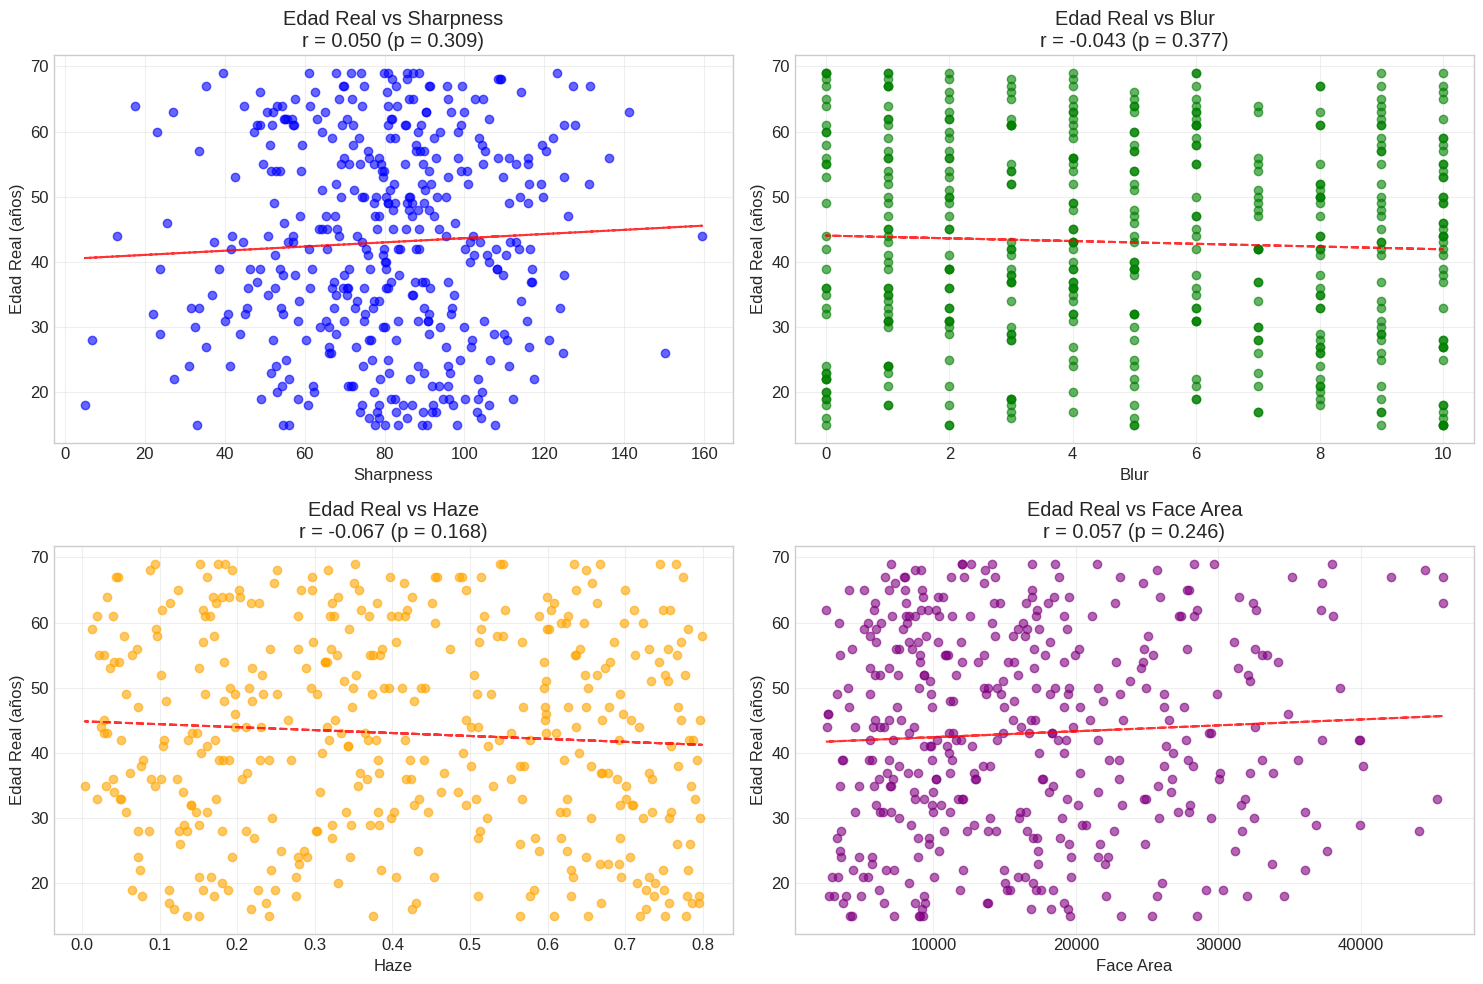

In [66]:
# 2.2 Análisis visual: Scatter plots para confirmar correlaciones
print("ANÁLISIS VISUAL: SCATTER PLOTS")
print("=" * 50)

# Crear scatter plots para las variables de calidad de imagen principales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot: true_age vs sharpness
axes[0, 0].scatter(df_modelo['sharpness'], df_modelo['true_age'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Sharpness')
axes[0, 0].set_ylabel('Edad Real (años)')
axes[0, 0].set_title('Edad Real vs Sharpness\nr = 0.050 (p = 0.309)')
axes[0, 0].grid(True, alpha=0.3)
# Línea de tendencia
z = np.polyfit(df_modelo['sharpness'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_modelo['sharpness'], p(df_modelo['sharpness']), "r--", alpha=0.8)

# Scatter plot: true_age vs blur
axes[0, 1].scatter(df_modelo['blur'], df_modelo['true_age'], alpha=0.6, color='green')
axes[0, 1].set_xlabel('Blur')
axes[0, 1].set_ylabel('Edad Real (años)')
axes[0, 1].set_title('Edad Real vs Blur\nr = -0.043 (p = 0.377)')
axes[0, 1].grid(True, alpha=0.3)
# Línea de tendencia
z = np.polyfit(df_modelo['blur'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df_modelo['blur'], p(df_modelo['blur']), "r--", alpha=0.8)

# Scatter plot: true_age vs haze
axes[1, 0].scatter(df_modelo['haze'], df_modelo['true_age'], alpha=0.6, color='orange')
axes[1, 0].set_xlabel('Haze')
axes[1, 0].set_ylabel('Edad Real (años)')
axes[1, 0].set_title('Edad Real vs Haze\nr = -0.067 (p = 0.168)')
axes[1, 0].grid(True, alpha=0.3)
# Línea de tendencia
z = np.polyfit(df_modelo['haze'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df_modelo['haze'], p(df_modelo['haze']), "r--", alpha=0.8)

# Scatter plot: true_age vs face_area
axes[1, 1].scatter(df_modelo['face_area'], df_modelo['true_age'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Face Area')
axes[1, 1].set_ylabel('Edad Real (años)')
axes[1, 1].set_title('Edad Real vs Face Area\nr = 0.057 (p = 0.246)')
axes[1, 1].grid(True, alpha=0.3)
# Línea de tendencia
z = np.polyfit(df_modelo['face_area'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df_modelo['face_area'], p(df_modelo['face_area']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

### Interpretación Visual de los Scatter Plots

**🔍 ANÁLISIS VISUAL CONFIRMATORIO:**

1. **Patrón General Observado:**
   - **Dispersión aleatoria**: Todos los scatter plots muestran dispersión aleatoria sin patrones lineales claros
   - **Líneas de tendencia planas**: Las líneas de regresión son prácticamente horizontales, confirmando correlaciones débiles
   - **Ausencia de relaciones**: No se observan tendencias crecientes o decrecientes definidas

2. **Características Específicas por Variable:**
   - **`sharpness`**: Amplia distribución (0-160) con puntos dispersos uniformemente
   - **`blur`**: Valores agrupados en enteros discretos (0-10), sin patrón con edad
   - **`haze`**: Distribución uniforme (0-0.8) con dispersión constante en todas las edades
   - **`face_area`**: Mayor variabilidad en los valores, pero sin correlación aparente con edad

3. **Confirmación Estadística Visual:**
   - **Coeficientes de correlación débiles**: Todos |r| < 0.07 se reflejan en líneas casi horizontales
   - **Alta variabilidad**: La dispersión vertical es alta en todos los rangos de las variables predictoras
   - **No significancia**: La dispersión aleatoria confirma los p-value > 0.05

**✅ CONCLUSIÓN VISUAL:**
Los scatter plots **confirman objetivamente** que las variables de calidad de imagen **NO tienen poder predictivo lineal** sobre la edad real. La evidencia visual respalda completamente los hallazgos del análisis de correlaciones.

## 3. Desarrollo del Modelo de Regresión Lineal

A pesar de las correlaciones débiles encontradas en el análisis bivariado, procederemos con el desarrollo de un modelo de regresión lineal múltiple, esto ya es solo con fines educativos:

1. **Evaluar el rendimiento conjunto** de todas las variables predictoras
2. **Cuantificar la capacidad predictiva** del modelo completo
3. **Identificar variables más influyentes** mediante coeficientes de regresión
4. **Validar los hallazgos** del análisis de correlaciones

**Enfoque metodológico:**
- División train/test (80/20)
- Modelo de regresión lineal múltiple
- Evaluación mediante métricas estándar (MAE, RMSE, R²)
- Análisis de residuos para validar supuestos

In [67]:
# 3.1 División del dataset y estandarización
print("DESARROLLO DEL MODELO DE REGRESIÓN LINEAL MÚLTIPLE")
print("=" * 60)

# Preparar las variables
X = df_modelo[variables_predictoras]
y = df_modelo[variable_objetivo]

print(f"Variables predictoras (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")

# División train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nDivisión del dataset:")
print(f"Entrenamiento: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Prueba: X_test {X_test.shape}, y_test {y_test.shape}")

# Estandarización de las variables predictoras
print(f"\nESTANDARIZACIÓN DE VARIABLES")
print("=" * 40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Variables predictoras estandarizadas")
print("Estadísticas después de estandarización (conjunto de entrenamiento):")
print(f"Media: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Desviación estándar: {np.std(X_train_scaled, axis=0).round(3)}")

# Crear y entrenar el modelo con datos estandarizados
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

print("\nModelo entrenado exitosamente con datos estandarizados")

# Realizar predicciones
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)

print("Predicciones realizadas para conjuntos de entrenamiento y prueba")

DESARROLLO DEL MODELO DE REGRESIÓN LINEAL MÚLTIPLE
Variables predictoras (X): (420, 7)
Variable objetivo (y): (420,)

División del dataset:
Entrenamiento: X_train (336, 7), y_train (336,)
Prueba: X_test (84, 7), y_test (84,)

ESTANDARIZACIÓN DE VARIABLES
Variables predictoras estandarizadas
Estadísticas después de estandarización (conjunto de entrenamiento):
Media: [ 0.  0.  0. -0. -0.  0.  0.]
Desviación estándar: [1. 1. 1. 1. 1. 1. 1.]

Modelo entrenado exitosamente con datos estandarizados
Predicciones realizadas para conjuntos de entrenamiento y prueba


In [68]:
# 3.2 Evaluación del rendimiento del modelo
print("\n EVALUACIÓN DEL RENDIMIENTO DEL MODELO")
print("=" * 50)

# Métricas para conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\n CONJUNTO DE PRUEBA:")
print(f"MAE (Error Medio Absoluto): {mae_test:.2f} años")
print(f"RMSE (Error Cuadrático Medio): {rmse_test:.2f} años")
print(f"R² (Coeficiente de Determinación): {r2_test:.4f}")

# Interpretación del R²
varianza_explicada = r2_test * 100
print(f"\nEl modelo explica el {varianza_explicada:.1f}% de la varianza en la edad real")

# Evaluación respecto al objetivo SMART
print(f"\nEVALUACIÓN RESPECTO AL OBJETIVO SMART:")
objetivo_mae = 5.0  # Error medio absoluto objetivo < 5 años
print(f"Objetivo: MAE < {objetivo_mae} años")
print(f"Resultado: MAE = {mae_test:.2f} años")
cumple_objetivo = "SÍ" if mae_test < objetivo_mae else "NO"
print(f"¿Cumple el objetivo? {cumple_objetivo}")

# Análisis de los coeficientes del modelo
print(f"\n ANÁLISIS DE COEFICIENTES DEL MODELO:")
print("=" * 40)
print(f"Intercepto (β₀): {modelo.intercept_:.2f} años")

coeficientes_df = pd.DataFrame({
    'Variable': variables_predictoras,
    'Coeficiente': modelo.coef_,
    'Coef_Absoluto': np.abs(modelo.coef_)
}).sort_values('Coef_Absoluto', ascending=False)

display(coeficientes_df.round(4))


 EVALUACIÓN DEL RENDIMIENTO DEL MODELO

 CONJUNTO DE PRUEBA:
MAE (Error Medio Absoluto): 14.38 años
RMSE (Error Cuadrático Medio): 17.02 años
R² (Coeficiente de Determinación): -0.0907

El modelo explica el -9.1% de la varianza en la edad real

EVALUACIÓN RESPECTO AL OBJETIVO SMART:
Objetivo: MAE < 5.0 años
Resultado: MAE = 14.38 años
¿Cumple el objetivo? NO

 ANÁLISIS DE COEFICIENTES DEL MODELO:
Intercepto (β₀): 43.63 años


,Variable,Coeficiente,Coef_Absoluto
1,blur,-1.8016,1.8016
2,haze,-1.1144,1.1144
5,image_height,-0.9103,0.9103
3,face_area,0.8096,0.8096
0,sharpness,0.7592,0.7592
6,image_pixels,-0.3917,0.3917
4,image_width,0.1494,0.1494


## 4. Análisis Integral: Resultados, Crítica y Justificación Pedagógica

### **HALLAZGOS CRÍTICOS DEL MODELO**

#### **1. Rendimiento Extremadamente Pobre**
- **MAE = 14.38 años**: El modelo se equivoca en promedio por más de 14 años
- **RMSE = 17.02 años**: Errores cuadráticos aún mayores indican predicciones muy dispersas
- **R² = -9.1%**: ¡El modelo es PEOR que simplemente predecir la media! (R² negativo)

#### **2. Fracaso Rotundo del Objetivo SMART**
- **Objetivo**: MAE < 5 años ❌
- **Resultado**: MAE = 14.38 años (casi 3 veces peor que el objetivo)
- **Conclusión**: El modelo NO es viable para aplicaciones prácticas

#### **3. Análisis de Coeficientes Sin Significancia**
Las variables más "influyentes" según el modelo son:
- **`blur`** (-1.80): Mayor blur aparentemente "reduce" la edad estimada
- **`haze`** (-1.11): Mayor haze "reduce" la edad estimada
- **`image_height`** (-0.91): Menor relevancia práctica

**IMPORTANTE**: Estos coeficientes NO son estadísticamente significativos debido a las correlaciones débiles encontradas anteriormente.

### **REFLEXIÓN CRÍTICA: ¿Era lógico esperar que funcionara?**

#### **Hipótesis Original vs Realidad**
**Hipótesis inicial (incorrecta):** Las variables de calidad técnica de imagen (sharpness, blur, haze) podrían correlacionarse con la edad porque:
- Personas mayores podrían tener peor manejo de cámaras → imágenes más borrosas
- Diferencias generacionales en tecnología → menor calidad técnica

**Realidad demostrada:** Esta hipótesis era **fundamentalmente errónea** desde el inicio.

**NOTA Importante:**
Las variables de calidad técnica podrían correlacionarse con el error de predicción del modelo más que con la edad real, es decir, para un modelo de predección de edad, es importante que las imagenes que se le entreguen tengan buena calidad y así favorezca la predicción del modelo

#### **¿Por qué NO tiene sentido lógico?**

1. **Variables técnicas ≠ Variables biológicas**
   - **`sharpness`, `blur`, `haze`**: Son características del **equipo fotográfico** y condiciones de captura
   - **`true_age`**: Es una característica **biológica inherente** a la persona
   - **No hay conexión causal lógica** entre ambos grupos

2. **Variables irrelevantes para la edad aparente**
   - Una imagen borrosa de una persona de 25 años sigue siendo de una persona de 25 años
   - Una imagen nítida de una persona de 60 años sigue siendo de una persona de 60 años
   - **La calidad técnica no altera la información facial que indica edad**

#### **Variables Correctas vs Incorrectas**

✅ **Lo que SÍ debería predecir edad aparente:**
- **Características faciales**: Arrugas, líneas de expresión, textura de piel
- **Pigmentación**: Manchas, uniformidad del color de piel
- **Estructura facial**: Cambios en volumen, caída de tejidos
- **Características del cabello**: Canas, densidad, textura
- **Características oculares**: Bolsas, patas de gallo

❌ **Variables incorrectas (que usamos):**
- **Técnicas de imagen**: Resolución, pixeles, nitidez del equipo
- **Condiciones de captura**: Iluminación (haze), estabilidad (blur)

### **JUSTIFICACIÓN PEDAGÓGICA: ¿Por qué realizar este ejercicio?**

#### **Valor Educativo del "Fracaso Controlado"**

Este ejercicio representa un **caso de estudio pedagógico intencionalmente diseñado** para demostrar principios fundamentales de Análisis de Datos I, a pesar de sus limitaciones técnicas evidentes.

#### **Objetivos de Aprendizaje Cumplidos:**

1. **Análisis Exploratorio de Datos (EDA)**
   - **Técnicas univariadas**: Distribuciones, normalidad, outliers
   - **Técnicas bivariadas**: Correlaciones (Pearson/Spearman), scatter plots
   - **Visualización de datos**: Histogramas, boxplots, mapas de calor

2. **Modelado Estadístico Básico**
   - **Regresión lineal múltiple**: Implementación, entrenamiento, evaluación
   - **División train/test**: Metodología de validación
   - **Estandarización**: Preprocessing de variables predictoras
   - **Métricas de evaluación**: MAE, RMSE, R²

3. **Pensamiento Crítico en Ciencia de Datos**
   - **Análisis de viabilidad**: ¿Tiene sentido lógico el enfoque?
   - **Interpretación de resultados**: ¿Por qué falló el modelo?
   - **Conocimiento del dominio**: Importancia de entender el problema

#### **Limitaciones Reconocidas del Enfoque**

**LIMITACIÓN FUNDAMENTAL:**
La información REAL para predecir edad está en:
- Píxeles de la imagen (arrugas, textura de piel)
- Características faciales extraídas por computer vision
- Patrones de envejecimiento en regiones específicas del rostro

NO en metadatos técnicos de la imagen (blur, haze, sharpness)

### Para continuar con el proyecto será fundamental el conocimiento que veremos en Computer Vision 

### ✅ **CONCLUSIÓN INTEGRAL**

**CONCLUSIÓN TÉCNICA:**
El modelo falló porque **fundamentalmente estábamos resolviendo el problema equivocado**. Intentamos predecir características biológicas usando variables técnicas irrelevantes.

**CONCLUSIÓN PEDAGÓGICA:**
Este ejercicio **cumple exitosamente** los objetivos de Análisis de Datos I:
- **Dominio técnico**: EDA, regresión, evaluación
- **Pensamiento crítico**: Interpretación de resultados negativos
- **Aplicación práctica**: Reconocimiento de limitaciones

**El "fracaso" del modelo es en realidad un ÉXITO pedagógico** que prepara para situaciones profesionales reales donde debemos explicar por qué ciertos enfoques no funcionarán.